In [1]:
"""
A non-blending lightGBM model that incorporates portions and ideas from various public kernels.
"""
DEBUG = True
VAL_RUN = True
WHERE = 'kaggle'
FILENO = 4
NCHUNK = 32000000
OFFSET = 75000000

MISSING32 = 999999999
MISSING8 = 255
PUBLIC_CUTOFF = 4032690

if WHERE=='kaggle':
	inpath = '/home/kai/data/kaggle/talkingdata/data/'
	pickle_path ='/home/kai/data/kaggle/talkingdata/data/training-and-validation-data-pickle/'
	suffix = ''
	outpath = ''
	savepath = ''
	oofpath = ''
	cores = 4
elif WHERE=='oof':
	inpath = '/home/kai/data/kaggle/talkingdata/data/'
	pickle_path = '/home/kai/data/kaggle/talkingdata/data/training-and-validation-data-pickle/'
	suffix = '.zip'
	outpath = '/home/kai/data/kaggle/talkingdata/data/training-and-validation-data-pickle/sub/'
	oofpath = '/home/kai/data/kaggle/talkingdata/data/training-and-validation-data-pickle/oof/'
	savepath = '/home/kai/data/kaggle/talkingdata/data/training-and-validation-data-pickle/save'
	cores = 7

In [2]:
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc
import matplotlib.pyplot as plt
import os

In [12]:
import pdb
def do_count( df, group_cols, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    pdb.set_trace()
    if show_agg:
        print( "Aggregating by ", group_cols , '...' )
    gp = df[group_cols][group_cols].groupby(group_cols).size().rename(agg_name).to_frame().reset_index()
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_countuniq( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    pdb.set_trace()
    if show_agg:
        print( "Counting unqiue ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )
    
def do_cumcount( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    pdb.set_trace()
    if show_agg:
        print( "Cumulative count by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].cumcount()
    df[agg_name]=gp.values
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_mean( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
    pdb.set_trace()
    if show_agg:
        print( "Calculating mean of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].mean().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_var( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
    pdb.set_trace()
    if show_agg:
        print( "Calculating variance of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].var().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

In [4]:
debug = DEBUG
if debug:
    print('*** debug parameter set: this is a test run for debugging purposes ***')

    
if VAL_RUN:
    nrows=122071522
    outpath = oofpath
else:
    nrows=184903890
nchunk=NCHUNK
val_size=2500000
frm=nrows-OFFSET
if debug:
    frm=0
    nchunk=100000
    val_size=10000
to=frm+nchunk
fileno = FILENO

*** debug parameter set: this is a test run for debugging purposes ***


In [5]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32',
        }


In [6]:
if VAL_RUN:
    print('loading train data...',frm,to)
    train_df = pd.read_pickle( pickle_path+"training.pkl.gz" )[frm:to]
    train_df['click_time'] = pd.to_datetime( train_df.click_time )
    print('loading test data...')
    if debug:
        public_cutoff = 10000
        test_df = pd.read_pickle( pickle_path+"validation.pkl.gz" )[:30000]
        test_df['click_time'] = pd.to_datetime( test_df.click_time )
        y_test = test_df['is_attributed'].values
        test_df.drop(['is_attributed'],axis=1,inplace=True)
    else:
        public_cutoff = PUBLIC_CUTOFF
        test_df = pd.read_pickle( pickle_path+"validation.pkl.gz" )
        test_df['click_time'] = pd.to_datetime( test_df.click_time )
        y_test = test_df['is_attributed'].values
        test_df.drop(['is_attributed'],axis=1,inplace=True)
else:
    print('loading train data...',frm,to)
    train_df = pd.read_csv(inpath+"train.csv", parse_dates=['click_time'], skiprows=range(1,frm), nrows=to-frm, dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])
    print('loading test data...')
    if debug:
        test_df = pd.read_csv(inpath+"test.csv", nrows=100000, parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
    else:
        test_df = pd.read_csv(inpath+"test.csv", parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
    train_df['click_id'] = MISSING32
    train_df['click_id'] = train_df.click_id.astype('uint32')

loading train data... 0 100000
loading test data...


In [7]:
train_df.head()

,ip,app,device,os,channel,click_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,0
1,17357,3,1,19,379,2017-11-06 14:33:34,0
2,35810,3,1,13,379,2017-11-06 14:34:12,0
3,45745,14,1,13,478,2017-11-06 14:34:52,0
4,161007,3,1,13,379,2017-11-06 14:35:08,0


In [8]:
len_train = len(train_df)
test_df['is_attributed'] = MISSING8
test_df['is_attributed'] = test_df.is_attributed.astype('uint8')
train_df=train_df.append(test_df)

In [9]:
len(train_df)

130000

In [10]:
del test_df
gc.collect()

35

In [11]:
print('Extracting new features...')
train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour.astype('uint8')
train_df['day'] = pd.to_datetime(train_df.click_time).dt.day.astype('uint8')

Extracting new features...


In [14]:
train_df.shape

(130000, 9)

In [15]:
train_df.head()

,ip,app,device,os,channel,click_time,is_attributed,hour,day
0,83230,3,1,13,379,2017-11-06 14:32:21,0,14,6
1,17357,3,1,19,379,2017-11-06 14:33:34,0,14,6
2,35810,3,1,13,379,2017-11-06 14:34:12,0,14,6
3,45745,14,1,13,478,2017-11-06 14:34:52,0,14,6
4,161007,3,1,13,379,2017-11-06 14:35:08,0,14,6


In [17]:
train_s = train_df.sample(frac=0.0001)

In [18]:
train_s

,ip,app,device,os,channel,click_time,is_attributed,hour,day
44600,101459,15,1,19,140,2017-11-06 16:00:49,0,16,6
96659,80476,3,1,19,409,2017-11-06 16:01:44,0,16,6
5392,67628,1,1,22,439,2017-11-09 04:00:05,255,4,9
59510,121347,9,1,20,134,2017-11-06 16:01:04,0,16,6
89676,67691,12,1,41,497,2017-11-06 16:01:36,0,16,6
39484,73487,3,2,65,153,2017-11-06 16:00:45,0,16,6
56658,82456,8,1,22,145,2017-11-06 16:01:01,0,16,6
6141,49793,9,1,53,107,2017-11-09 04:00:06,255,4,9
97929,4559,18,1,13,121,2017-11-06 16:01:46,0,16,6
2375,90643,8,1,19,145,2017-11-09 04:00:02,255,4,9


In [22]:
train_s.set_value(44600, 'ip', 4559)

,ip,app,device,os,channel,click_time,is_attributed,hour,day
44600,4559,15,1,19,140,2017-11-06 16:00:49,0,16,6
96659,80476,3,1,19,409,2017-11-06 16:01:44,0,16,6
5392,67628,1,1,22,439,2017-11-09 04:00:05,255,4,9
59510,121347,9,1,20,134,2017-11-06 16:01:04,0,16,6
89676,67691,12,1,41,497,2017-11-06 16:01:36,0,16,6
39484,73487,3,2,65,153,2017-11-06 16:00:45,0,16,6
56658,82456,8,1,22,145,2017-11-06 16:01:01,0,16,6
6141,49793,9,1,53,107,2017-11-09 04:00:06,255,4,9
97929,4559,18,1,13,121,2017-11-06 16:01:46,0,16,6
2375,90643,8,1,19,145,2017-11-09 04:00:02,255,4,9


In [35]:
do_var( train_s, ['ip', 'day', 'channel'], 'hour', 'ip_tchan_count', show_max=True )

> <ipython-input-12-f5fc235c38ec>(56)do_var()
-> if show_agg:
(Pdb) n
> <ipython-input-12-f5fc235c38ec>(57)do_var()
-> print( "Calculating variance of ", counted, " by ", group_cols , '...' )
(Pdb) n
Calculating variance of  hour  by  ['ip', 'day', 'channel'] ...
> <ipython-input-12-f5fc235c38ec>(58)do_var()
-> gp = df[group_cols+[counted]].groupby(group_cols)[counted].var().reset_index().rename(columns={counted:agg_name})
(Pdb) df[group_cols+[counted]].groupby(group_cols)[counted].var()
ip        day  channel
4559.0    6.0  121.0     NaN
               140.0     NaN
26995.0   6.0  477.0     NaN
49793.0   9.0  107.0     NaN
67691.0   6.0  497.0     NaN
73487.0   6.0  153.0     NaN
73582.0   6.0  128.0     NaN
80476.0   6.0  409.0     NaN
          9.0  439.0     NaN
82456.0   6.0  145.0     NaN
90643.0   9.0  145.0     NaN
121347.0  6.0  134.0     NaN
180462.0  6.0  477.0     NaN
Name: hour, dtype: float64
(Pdb) df[group_cols+[counted]].groupby(group_cols)[counted].unique()
ip        d

BdbQuit: 

In [15]:
print('Extracting aggregation features...')
train_df = do_cumcount( train_df, ['ip', 'device', 'os'], 'app', 'X1', show_max=True ); gc.collect()
train_df = do_cumcount( train_df, ['ip'], 'os', 'X7', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip'], 'channel', 'X0', 'uint8', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip', 'day'], 'hour', 'X2', 'uint8', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip'], 'app', 'X3', 'uint8', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip', 'app'], 'os', 'X4', 'uint8', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip'], 'device', 'X5', 'uint16', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['app'], 'channel', 'X6', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip', 'device', 'os'], 'app', 'X8', show_max=True ); gc.collect()
train_df = do_count( train_df, ['ip', 'day', 'hour'], 'ip_tcount', show_max=True ); gc.collect()
train_df = do_count( train_df, ['ip', 'app'], 'ip_app_count', show_max=True ); gc.collect()
train_df = do_count( train_df, ['ip', 'app', 'os'], 'ip_app_os_count', 'uint16', show_max=True ); gc.collect()
train_df = do_var( train_df, ['ip', 'day', 'channel'], 'hour', 'ip_tchan_count', show_max=True ); gc.collect()
train_df = do_var( train_df, ['ip', 'app', 'os'], 'hour', 'ip_app_os_var', show_max=True ); gc.collect()
train_df = do_var( train_df, ['ip', 'app', 'channel'], 'day', 'ip_app_channel_var_day', show_max=True ); gc.collect()
train_df = do_mean( train_df, ['ip', 'app', 'channel'], 'hour', 'ip_app_channel_mean_hour', show_max=True ); gc.collect()

Extracting aggregation features...
Cumulative count by  ['ip', 'device', 'os'] ...
X1 max value =  174
Cumulative count by  ['ip'] ...
X7 max value =  678
Counting unqiue  channel  by  ['ip'] ...
X0 max value =  75
Counting unqiue  hour  by  ['ip', 'day'] ...
X2 max value =  3
Counting unqiue  app  by  ['ip'] ...
X3 max value =  31
Counting unqiue  os  by  ['ip', 'app'] ...
X4 max value =  32
Counting unqiue  device  by  ['ip'] ...
X5 max value =  5
Counting unqiue  channel  by  ['app'] ...
X6 max value =  29
Counting unqiue  app  by  ['ip', 'device', 'os'] ...
X8 max value =  21
Aggregating by  ['ip', 'day', 'hour'] ...
ip_tcount max value =  610
Aggregating by  ['ip', 'app'] ...
ip_app_count max value =  164
Aggregating by  ['ip', 'app', 'os'] ...
ip_app_os_count max value =  44
Calculating variance of  hour  by  ['ip', 'day', 'channel'] ...
ip_tchan_count max value =  2.0
Calculating variance of  hour  by  ['ip', 'app', 'os'] ...
ip_app_os_var max value =  72.0
Calculating variance 

56

In [19]:
print('Doing nextClick...')
predictors=[]
new_feature = 'nextClick'
D=2**26
train_df['category'] = (train_df['ip'].astype(str) + "_" + train_df['app'].astype(str) + "_" + train_df['device'].astype(str) \
        + "_" + train_df['os'].astype(str)).apply(hash) % D
click_buffer= np.full(D, 3000000000, dtype=np.uint32)
train_df['epochtime']= train_df['click_time'].astype(np.int64) // 10 ** 9
next_clicks= []
for category, t in zip(reversed(train_df['category'].values), reversed(train_df['epochtime'].values)):
    next_clicks.append(click_buffer[category]-t)
    click_buffer[category]= t
del(click_buffer)
QQ= list(reversed(next_clicks))
train_df.drop(['epochtime','category','click_time'], axis=1, inplace=True)
train_df[new_feature] = pd.Series(QQ).astype('float32')
predictors.append(new_feature)
train_df[new_feature+'_shift'] = train_df[new_feature].shift(+1).values
predictors.append(new_feature+'_shift')
del QQ, next_clicks
gc.collect()

Doing nextClick...


63

In [20]:
train_df.shape

(130000, 26)

In [24]:
print("vars and data type: ")
train_df.info()
train_df['ip_tcount'] = train_df['ip_tcount'].astype('uint16')
train_df['ip_app_count'] = train_df['ip_app_count'].astype('uint16')
train_df['ip_app_os_count'] = train_df['ip_app_os_count'].astype('uint16')

target = 'is_attributed'
predictors.extend(['app','device','os', 'channel', 'hour', 'day',
              'ip_tcount', 'ip_tchan_count', 'ip_app_count',
              'ip_app_os_count', 'ip_app_os_var',
              'ip_app_channel_var_day','ip_app_channel_mean_hour',
              'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8'])
categorical = ['app', 'device', 'os', 'channel', 'hour', 'day']
print('predictors',predictors)

vars and data type: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 130000 entries, 0 to 129999
Data columns (total 26 columns):
ip                          130000 non-null uint32
app                         130000 non-null uint16
device                      130000 non-null uint16
os                          130000 non-null uint16
channel                     130000 non-null uint16
is_attributed               130000 non-null uint8
hour                        130000 non-null uint8
day                         130000 non-null uint8
X1                          130000 non-null uint32
X7                          130000 non-null uint32
X0                          130000 non-null uint8
X2                          130000 non-null uint8
X3                          130000 non-null uint8
X4                          130000 non-null uint8
X5                          130000 non-null uint16
X6                          130000 non-null uint32
X8                          130000 non-null uint32
ip_tcoun

In [25]:
val_size

10000

In [26]:
test_df = train_df[len_train:]
val_df = train_df[(len_train-val_size):len_train]
train_df = train_df[:(len_train-val_size)]

In [27]:
print("train size: ", len(train_df))
print("valid size: ", len(val_df))
print("test size : ", len(test_df))

train size:  90000
valid size:  10000
test size :  30000


In [28]:
test_df.to_pickle('test.pkl.gz')
del test_df
gc.collect()

2659

In [29]:
print("Training...")
start_time = time.time()

objective='binary' 
metrics='auc'
early_stopping_rounds=30 
verbose_eval=True 
num_boost_round=1000
categorical_features=categorical
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': objective,
    'metric':metrics,
    'learning_rate': 0.10,
    #'is_unbalance': 'true', # replaced with scale_pos_weight argument
    'num_leaves': 7,  # 2^max_depth - 1
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':200, # because training data is extremely unbalanced 
    'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 0,  # L2 regularization term on weights
    'nthread': cores,
    'verbose': 0,
    'metric':metrics
}


Training...


In [30]:
print("preparing validation datasets")
xgtrain = lgb.Dataset(train_df[predictors].values, label=train_df[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
                      
print( train_df[predictors].head() )
print( train_df[target].head() )
print( val_df[predictors].head() )
print( val_df[target].head() )

del train_df
if WHERE != 'kaggle':
    xgtrain.save_binary('xgtrain.bin')
    del xgtrain
xgvalid = lgb.Dataset(val_df[predictors].values, label=val_df[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
del val_df
gc.collect()

preparing validation datasets
      nextClick  nextClick_shift  app  device  os  channel  hour  day  \
0  5.340000e+03              NaN    3       1  13      379    14    6   
1  1.490021e+09     5.340000e+03    3       1  19      379    14    6   
2  1.490021e+09     1.490021e+09    3       1  13      379    14    6   
3  5.110000e+03     1.490021e+09   14       1  13      478    14    6   
4  1.490021e+09     5.110000e+03    3       1  13      379    14    6   

   ip_tcount  ip_tchan_count ...  ip_app_channel_mean_hour  X0  X1  X2  X3  \
0          1             NaN ...                      14.0  19   0   2  10   
1          1             0.5 ...                      14.5  12   0   3   8   
2          1             NaN ...                      14.0  14   0   2   9   
3          1             2.0 ...                      14.0  46   0   2  21   
4          1             NaN ...                      14.0   1   0   1   1   

   X4  X5  X6  X7  X8  
0   3   1  29   0   7  
1   3   1  29 

188

In [32]:
evals_results = {}

if WHERE != 'kaggle':
    xgtrain = lgb.Dataset('xgtrain.bin',
                          feature_name=predictors,
                          categorical_feature=categorical
                          )
                      
print( lgb_params )
bst = lgb.train(lgb_params, 
                 xgtrain, 
                 valid_sets=[xgvalid], 
                 valid_names=['valid'], 
                 evals_result=evals_results, 
                 num_boost_round=num_boost_round,
                 early_stopping_rounds=early_stopping_rounds,
                 verbose_eval=10, 
                 feval=None)

print("\nModel Report")
print("bst.best_iteration: ", bst.best_iteration)
print(metrics+":", evals_results['valid'][metrics][bst.best_iteration-1])


print('[{}]: model training time'.format(time.time() - start_time))

{'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'learning_rate': 0.1, 'num_leaves': 7, 'max_depth': 3, 'min_child_samples': 100, 'max_bin': 100, 'subsample': 0.7, 'subsample_freq': 1, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'scale_pos_weight': 200, 'subsample_for_bin': 200000, 'min_split_gain': 0, 'reg_alpha': 0, 'reg_lambda': 0, 'nthread': 4, 'verbose': 0}
Training until validation scores don't improve for 30 rounds.
[10]	valid's auc: 0.925651
[20]	valid's auc: 0.924852
[30]	valid's auc: 0.930286
Early stopping, best iteration is:
[7]	valid's auc: 0.935601

Model Report
bst.best_iteration:  7
auc: 0.935601326731
[273.9010593891144]: model training time


/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1027: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:668: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Plot feature importances


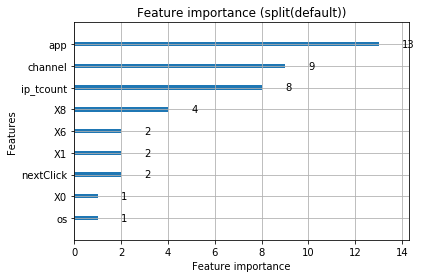

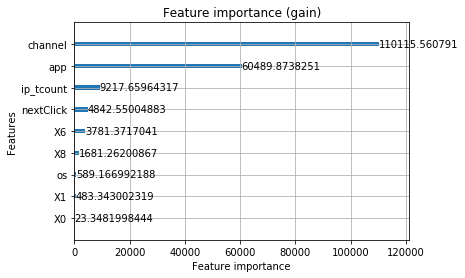

In [38]:
if WHERE!='gcloud':
    print('Plot feature importances')
    lgb.plot_importance(bst, max_num_features=100, title='Feature importance (split(default))')
    lgb.plot_importance(bst, max_num_features=100, title='Feature importance (gain)', importance_type='gain')
    plt.show()

In [39]:
print("Re-reading test data...")
test_df = pd.read_pickle('test.pkl.gz')
sub = pd.DataFrame()

print("Predicting...")
y_pred = bst.predict(test_df[predictors],num_iteration=bst.best_iteration)
outsuf = ''
if VAL_RUN:
    print(  "\n\nFULL VALIDATION SCORE:    ", 
            roc_auc_score( y_test, y_pred )  )
    print(  "PUBLIC VALIDATION SCORE:  ", 
            roc_auc_score( y_test[:public_cutoff], y_pred[:public_cutoff] )  )
    print(  "PRIVATE VALIDATION SCORE: ",
            roc_auc_score( y_test[public_cutoff:], y_pred[public_cutoff:] )  )
    outsuf = '_val'
    sub['click_id'] = pd.Series(range(len(test_df))).astype('uint32').values
else:
    sub['click_id'] = test_df['click_id'].astype('uint32').values

Re-reading test data...
Predicting...


FULL VALIDATION SCORE:     0.882247359664
PUBLIC VALIDATION SCORE:   0.877059262228
PRIVATE VALIDATION SCORE:  0.885658487732


In [40]:
public_cutoff

10000

In [41]:
if WHERE != 'kaggle':
    os.remove('xgtrain.bin')
os.remove('test.pkl.gz')
sub['is_attributed'] = y_pred
if not debug:
    print("\nwriting...")
    if WHERE=='kaggle':
        sub.to_csv('sub_it%d'%(fileno)+outsuf+'.csv', index=False, float_format='%.9f')
    else:
        sub.to_csv('sub_it%d'%(fileno)+outsuf+'.csv.gz', index=False, float_format='%.9f', compression='gzip')
print("\ndone...")
print( sub.head(10) )


done...
   click_id  is_attributed
0         0       0.246625
1         1       0.293610
2         2       0.270252
3         3       0.464478
4         4       0.445711
5         5       0.244269
6         6       0.337466
7         7       0.251664
8         8       0.303375
9         9       0.251664
